# Train a ML model for trait retrieval 
Based on simulated spectra from RTMs

In [101]:
import sys
import os
from pathlib import Path
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio

import torch
import torch.nn as nn
import torch.optim as optim

base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent

## 1. Get data
Load LUT tables in a dataframe and split into train and test (70/30 split)

In [62]:
safe_dir = base_dir.joinpath(Path('results/lut_based_inversion/eschikon'))

In [70]:
df = pd.DataFrame()

for scene_dir in safe_dir.glob('*.SAFE'):
  # Load LUT into dataframe
  with open(scene_dir.joinpath('all_phases_lai-cab-ccc-car_lut.pkl'), 'rb') as f:
    df = pd.concat([df, pickle.load(f)])

In [71]:
df.drop(columns=['n', 'cab', 'car', 'ant', 'cbrown', 'cw', 'cm', 'lidfa', 'hspot',
       'rsoil', 'psoil', 'lidfb', 'tts', 'tto', 'psi', 'typelidf', 'ccc', 'B01', 'B08', 'B09', 'B10'], inplace=True)

In [73]:
# Splitting the DataFrame into features (X) and target variable (y)
X = df.drop('lai', axis=1)
y = df['lai']

# Splitting the data into 70% training and 30% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [74]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [75]:
print('Training size', len(X_train))
print('Test size', len(X_test))

Training size 1565095
Test size 670756


In [76]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plotting the histogram for y_test
sns.histplot(y_test, bins=30, color='blue', alpha=0.7, ax=axs[0])
axs[0].set_title('Histogram of test LAI')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Frequency')

# Plotting the histogram for y
sns.histplot(y, bins=30, color='green', alpha=0.7, ax=axs[1])
axs[1].set_title('Histogram of train LAI')
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Frequency')

# Adjust layout for better presentation
plt.tight_layout()
plt.show()

## 2. Set up model: Random Forest

In [79]:
random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_regressor.fit(X_train, y_train)

y_pred = random_forest_regressor.predict(X_test)

# Evaluate the performance of the model (for example, using Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

Mean Squared Error: 0.37
Root Mean Squared Error: 0.60


In [80]:
# Save model

model_filename = 'random_forest_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(random_forest_regressor, model_file)

"""
with open(model_filename, 'rb') as model_file:
    loaded_rf_model = pickle.load(model_file)
"""

"\nwith open(model_filename, 'rb') as model_file:\n    loaded_rf_model = pickle.load(model_file)\n"

### Analyse residuals and perfromance

In [8]:
# Save model

model_filename = 'random_forest_model.pkl'
with open(model_filename, 'rb') as model_file:
    loaded_rf_model = pickle.load(model_file)

In [3]:
y_pred = loaded_rf_model.predict(X_test)

NameError: name 'X_test' is not defined

In [15]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.savefig('residuals.png')

In [21]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.savefig('actual_vs_predicted.png')

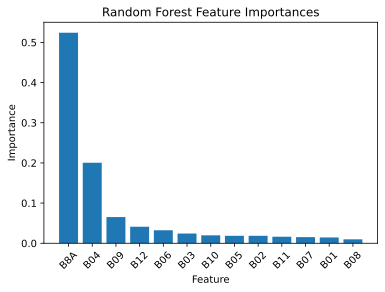

In [15]:
# Feature importance

# Get feature importances
feature_importances = loaded_rf_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns.tolist()  # Replace with the actual names of your features

# Sort the features based on their importance
sorted_indices = feature_importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(6, 4))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices])
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.show()

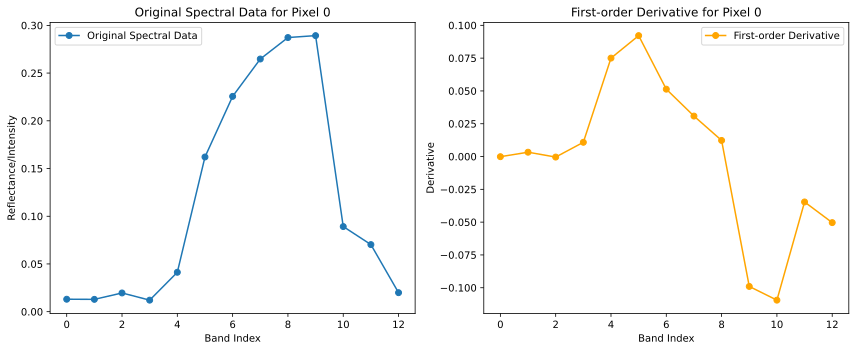

In [28]:
# Compute the first-order derivative for each pixel
derivative_X = X_train.apply(np.gradient, axis=1)

# Print the original spectral data and the derivative for the first pixel
print("Original Spectral Data for Pixel 1:", X_train.iloc[0, :].values)
print("Derivative for Pixel 1:", derivative_X.iloc[0])

pixel_index = 0
original_data = X_train.iloc[pixel_index, :].values
derivative_data = derivative_X.iloc[pixel_index]

# Create a range of wavelengths or bands for plotting
wavelengths = np.arange(len(original_data))

# Plot the original spectral data and the first-order derivative side by side
plt.figure(figsize=(12, 5))

# Plot the original spectral data
plt.subplot(1, 2, 1)
plt.plot(wavelengths, original_data, marker='o', label='Original Spectral Data')
plt.title('Original Spectral Data for Pixel {}'.format(pixel_index))
plt.xlabel('Band Index')
plt.ylabel('Reflectance/Intensity')
plt.legend()

# Plot the first-order derivative
plt.subplot(1, 2, 2)
plt.plot(wavelengths, derivative_data, marker='o', color='orange', label='First-order Derivative')
plt.title('First-order Derivative for Pixel {}'.format(pixel_index))
plt.xlabel('Band Index')
plt.ylabel('Derivative')
plt.legend()

plt.tight_layout()
plt.show()


In [47]:
# Retrain with dervative info and compare change in performance

derivative_X = X_train.apply(np.gradient, axis=1)
derivative_X = pd.DataFrame(derivative_X.tolist(), columns=[f'Derivative_{col}' for col in X_train.columns])
derivative_X_test = X_test.apply(np.gradient, axis=1)
derivative_X_test = pd.DataFrame(derivative_X_test.tolist(), columns=[f'Derivative_{col}' for col in X_train.columns])

X_train_combined = pd.concat([X_train, derivative_X.add_prefix('Derivative_')], axis=1)
X_test_combined = pd.concat([X_test, derivative_X_test.add_prefix('Derivative_')], axis=1)

# Retrain the Random Forest regressor with the combined data
random_forest_regressor_combined = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_regressor_combined.fit(X_train_combined, y_train)

# Make predictions on the test set
y_pred_combined = random_forest_regressor_combined.predict(X_test_combined)

# Evaluate the performance of the model with derivative information
mse_combined = mean_squared_error(y_test, y_pred_combined)
rmse_combined = np.sqrt(mse_combined)
print("Performance with Derivative Information:")
print(f"Mean Squared Error: {mse_combined:.2f}")
print(f"Root Mean Squared Error: {rmse_combined:.2f}")

# Feature importances
feature_importances_combined = random_forest_regressor_combined.feature_importances_
feature_names_combined = X_train_combined.columns
importance_df = pd.DataFrame({'Feature': feature_names_combined, 'Importance': feature_importances_combined})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(importance_df)

Performance with Derivative Information:
Mean Squared Error: 0.18
Root Mean Squared Error: 0.43

Feature Importances:
                      Feature  Importance
19  Derivative_Derivative_B07    0.673672
23  Derivative_Derivative_B10    0.061605
15  Derivative_Derivative_B03    0.051357
3                         B04    0.019772
12                        B12    0.019241
0                         B01    0.018615
21  Derivative_Derivative_B8A    0.017756
14  Derivative_Derivative_B02    0.016978
20  Derivative_Derivative_B08    0.016513
24  Derivative_Derivative_B11    0.015119
18  Derivative_Derivative_B06    0.014092
13  Derivative_Derivative_B01    0.013950
16  Derivative_Derivative_B04    0.009878
25  Derivative_Derivative_B12    0.006881
22  Derivative_Derivative_B09    0.006199
2                         B03    0.005816
9                         B09    0.005261
11                        B11    0.004186
4                         B05    0.003881
1                         B02    0.003244


In [48]:
# Save model

model_filename = 'random_forest_model_deriv.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(random_forest_regressor_combined, model_file)

"""
with open(model_filename, 'rb') as model_file:
    loaded_rf_model = pickle.load(model_file)
"""

"\nwith open(model_filename, 'rb') as model_file:\n    loaded_rf_model = pickle.load(model_file)\n"

## 2.B Train a neural network

In [13]:
# Normalize input data
scaler_X = MinMaxScaler()
X_train_normalized = scaler_X.fit_transform(X_train)
X_test_normalized = scaler_X.transform(X_test)

# Normalize target variable
scaler_y = MinMaxScaler()
y_train_normalized = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Reshape to ensure a 2D array
y_test_normalized = scaler_y.transform(y_test.values.reshape(-1, 1))

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_normalized, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)

class ImprovedRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(ImprovedRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return self.fc3(x)

# Instantiate the improved model, loss function, and optimizer
improved_model = ImprovedRegressionModel(input_size=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)

# Training the model
epochs = 100  # Train for more epochs
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = improved_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Add L2 regularization
    l2_lambda = 0.001
    l2_reg = torch.tensor(0., requires_grad=True)
    for param in improved_model.parameters():
        l2_reg = l2_reg + torch.norm(param)
    
    loss = loss + l2_lambda * l2_reg
    
    loss.backward()
    optimizer.step()

# Make predictions with the improved model
with torch.no_grad():
    improved_model.eval()
    y_pred_tensor_improved = improved_model(X_test_tensor)
    improved_model.train()

# Convert predictions back to numpy array
y_pred_normalized_improved = y_pred_tensor_improved.numpy().flatten()

# Denormalize predictions for interpretability
y_pred_denormalized_improved = scaler_y.inverse_transform(y_pred_normalized_improved.reshape(-1, 1)).flatten()

# Evaluate the performance of the denormalized predictions
mse_denormalized_improved = mean_squared_error(y_test, y_pred_denormalized_improved)
rmse_denormalized_improved = np.sqrt(mse_denormalized_improved)
print(f"Improved Denormalized Mean Squared Error: {mse_denormalized_improved:.2f}")
print(f"Improved Denormalized Root Mean Squared Error: {rmse_denormalized_improved:.2f}")

Improved Denormalized Mean Squared Error: 1.87
Improved Denormalized Root Mean Squared Error: 1.37


In [40]:
residuals = y_test - y_pred_denormalized
plt.scatter(y_test, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.savefig('residuals_nn.png')

## 2.C Gaussian Process Regression

Subsample AND apply PCA

In [107]:
# Sample the training set since it is too big

np.random.seed(42)
sampled_indices = np.random.choice(X_train.reset_index(drop=True).index, size=10000, replace=False)
X_sampled = X_train.loc[sampled_indices]
y_sampled = y_train.reset_index(drop=True).loc[sampled_indices]

In [111]:
# Apply PCA to the input data
pca = PCA(n_components=5)  # Choose the number of components as needed
X_train_pca = pca.fit_transform(X_sampled)
X_test_pca = pca.transform(X_test)

# Normalize input data
scaler_X = MinMaxScaler()
X_train_normalized = scaler_X.fit_transform(X_train_pca)
X_test_normalized = scaler_X.transform(X_test_pca)

# Normalize target variable
scaler_y = MinMaxScaler()
y_train_normalized = scaler_y.fit_transform(y_sampled.values.reshape(-1, 1))
y_test_normalized = scaler_y.transform(y_test.values.reshape(-1, 1))

# Define the Gaussian Process kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))

# Instantiate the Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

# Train the Gaussian Process Regressor
gpr.fit(X_train_normalized, y_train_normalized)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, random_state=42)

In [113]:
# Make predictions
y_pred_normalized, sigma = gpr.predict(X_test_normalized, return_std=True)

In [116]:
# Denormalize predictions for interpretability
y_pred_denormalized = scaler_y.inverse_transform(y_pred_normalized.reshape(1, -1)).flatten()

# Evaluate the performance of the denormalized predictions
mse_denormalized = mean_squared_error(y_test, y_pred_denormalized)
rmse_denormalized = np.sqrt(mse_denormalized)
print(f"Denormalized Mean Squared Error: {mse_denormalized:.2f}")
print(f"Denormalized Root Mean Squared Error: {rmse_denormalized:.2f}")

Denormalized Mean Squared Error: 4.99
Denormalized Root Mean Squared Error: 2.23


# 

## 3. Inference: get LAI of (new) images (with RF)

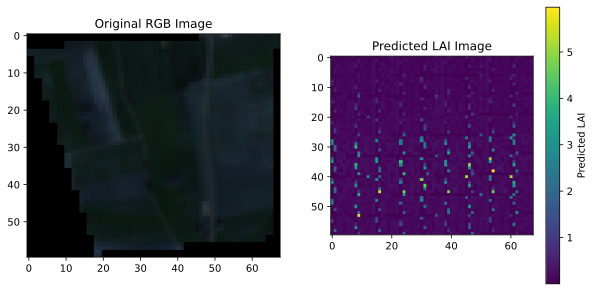

In [109]:
# Test on S2 images

img_path = base_dir.joinpath('results/lut_based_inversion/eschikon/S2A_MSIL2A_20190226T102021_R065_T32TMT_20201007T205009.SAFE/SRF_S2.tiff')

with rasterio.open(img_path) as src:
    # Read the image data
    img_data = src.read()
    # There are 10 bands: B02, B03, B04, B05, B06, B07, B8A, B11, B12, SCL
    # Use only the 9 first ones
    

# Reshape the image data to have one row for each pixel and one column for each band
num_bands, height, width = img_data[:9].shape
pixel_values = img_data[:9].reshape((-1, num_bands))

# Create a DataFrame with pixel values and band names
band_names = X_train.columns
pixel_df = pd.DataFrame(pixel_values, columns=band_names)

predictions = random_forest_regressor.predict(pixel_df)

# Reshape predictions back to the original image shape
predictions_image = predictions.reshape((height, width))

# Plot the original image and the predicted image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
rgb_image = img_data[[0, 1, 2], :, :].transpose(1, 2, 0)
plt.imshow(rgb_image *1.5) # Multiply by factor to brighten
plt.title('Original RGB Image')

plt.subplot(1, 2, 2)
plt.imshow(predictions_image, cmap='viridis')
plt.title('Predicted LAI Image')
colorbar = plt.colorbar()
colorbar.set_label('Predicted LAI')

plt.show()


In [2]:
# Try on SwissFutureFarm

safe_test_dir = base_dir.joinpath(Path('results/lut_based_inversion/SwissFutureFarm'))

df = pd.DataFrame()
for scene_dir in safe_test_dir.glob('*.SAFE'):
  # Load LUT into dataframe
  with open(scene_dir.joinpath('all_phases_lai-cab-ccc-car_lut.pkl'), 'rb') as f:
    df = pd.concat([df, pickle.load(f)])

df.drop(columns=['n', 'cab', 'car', 'ant', 'cbrown', 'cw', 'cm', 'lidfa', 'hspot',
       'rsoil', 'psoil', 'lidfb', 'tts', 'tto', 'psi', 'typelidf', 'ccc'], inplace=True)
       
# Splitting the DataFrame into features (X) and target variable (y)
X = df.drop('lai', axis=1)
y = df['lai']

In [3]:
model_filename = 'random_forest_model.pkl'
with open(model_filename, 'rb') as model_file:
    loaded_rf_model = pickle.load(model_file)

In [4]:
# Make predictions on the new data
predictions = loaded_rf_model.predict(X)
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (out of domain test set): {mse:.2f}')
print(f"Root Mean Squared Error (out of domain test set): {rmse:.2f}")

Mean Squared Error (out of domain test set): 0.22
Root Mean Squared Error (out of domain test set): 0.47


In [6]:
y_pred = loaded_rf_model.predict(X)
residuals = y - y_pred
plt.scatter(y, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.savefig('residuals_ood.png')

### Test performance in different growth phases (SwissFutureFarm)

In [5]:
# Germination - End of tillering

safe_test_dir = base_dir.joinpath(Path('results/lut_based_inversion/SwissFutureFarm'))

df = pd.DataFrame()
for scene_dir in safe_test_dir.glob('*.SAFE'):
  # Load LUT into dataframe
  with open(scene_dir.joinpath('germination-endoftillering_lai-cab-ccc-car_lut_no-constraints.pkl'), 'rb') as f:
    df = pd.concat([df, pickle.load(f)])

df.drop(columns=['n', 'cab', 'car', 'ant', 'cbrown', 'cw', 'cm', 'lidfa', 'hspot',
       'rsoil', 'psoil', 'lidfb', 'tts', 'tto', 'psi', 'typelidf', 'ccc'], inplace=True)
       
# Splitting the DataFrame into features (X) and target variable (y)
X = df.drop('lai', axis=1)
y = df['lai']

# Make predictions on the new data
predictions = loaded_rf_model.predict(X)
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (out of domain test set): {mse:.2f}')
print(f"Root Mean Squared Error (out of domain test set): {rmse:.2f}")

Mean Squared Error (out of domain test set): 0.07
Root Mean Squared Error (out of domain test set): 0.27


In [6]:
# Stem elongation - End of heading

safe_test_dir = base_dir.joinpath(Path('results/lut_based_inversion/SwissFutureFarm'))

df = pd.DataFrame()
for scene_dir in safe_test_dir.glob('*.SAFE'):
  # Load LUT into dataframe
  with open(scene_dir.joinpath('stemelongation-endofheading_lai-cab-ccc-car_lut_no-constraints.pkl'), 'rb') as f:
    df = pd.concat([df, pickle.load(f)])

df.drop(columns=['n', 'cab', 'car', 'ant', 'cbrown', 'cw', 'cm', 'lidfa', 'hspot',
       'rsoil', 'psoil', 'lidfb', 'tts', 'tto', 'psi', 'typelidf', 'ccc'], inplace=True)
       
# Splitting the DataFrame into features (X) and target variable (y)
X = df.drop('lai', axis=1)
y = df['lai']

# Make predictions on the new data
predictions = loaded_rf_model.predict(X)
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (out of domain test set): {mse:.2f}')
print(f"Root Mean Squared Error (out of domain test set): {rmse:.2f}")

Mean Squared Error (out of domain test set): 1.91
Root Mean Squared Error (out of domain test set): 1.38


## 4. Improve model
- Standardise input data ( we actually dont need to normalise for RF models)
- K-fold cross validation
- Hyperparameter tuning

analyse how many min traning data

In [12]:
# K-fold cross validation

random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # You can adjust the number of splits
cv_results = cross_val_score(random_forest_regressor, X, y, cv=kfold, scoring='neg_mean_squared_error')

# Convert negative mean squared error to positive root mean squared error
rmse_scores = np.sqrt(-cv_results)

# Print the results
print("Cross-Validation Results:")
print(f"Root Mean Squared Error for each fold: {rmse_scores}")
print(f"Mean Root Mean Squared Error: {rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})")


Cross-Validation Results:
Root Mean Squared Error for each fold: [0.56672206 0.5647419  0.56658124 0.56778057 0.56784404]
Mean Root Mean Squared Error: 0.57 (+/- 0.00)


In [13]:
# Save model

model_filename = 'random_forest_model_kfold.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(random_forest_regressor, model_file)

"""
with open(model_filename, 'rb') as model_file:
    loaded_rf_model = pickle.load(model_file)
"""

"\nwith open(model_filename, 'rb') as model_file:\n    loaded_rf_model = pickle.load(model_file)\n"

In [17]:
# Adding data standardisation -> careful about the interpretation of the results (LAI)

random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
model = make_pipeline(StandardScaler(), random_forest_regressor) # standard scaler assumes gaussian variables. Might need min-max if not the case
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # You can adjust the number of splits
cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_results)

# Print the results
print("Cross-Validation Results:")
print(f"Root Mean Squared Error for each fold: {rmse_scores}")
print(f"Mean Root Mean Squared Error: {rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})")

Cross-Validation Results:
Root Mean Squared Error for each fold: [0.56703974 0.56477033 0.56669391 0.56776578 0.5680809 ]
Mean Root Mean Squared Error: 0.57 (+/- 0.00)


In [18]:
# Save model

model_filename = 'random_forest_model_norm.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(random_forest_regressor, model_file)

"""
with open(model_filename, 'rb') as model_file:
    loaded_rf_model = pickle.load(model_file)
"""

"\nwith open(model_filename, 'rb') as model_file:\n    loaded_rf_model = pickle.load(model_file)\n"

In [10]:
# Performance in function of the train size

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables
min_train_size = 10  # Minimum number of training data points
max_train_size = len(X_train)  # Maximum number of training data points
step_size = 10  #

# Lists to store results
train_sizes = [10000, 100000, 500000, 1000000]
mean_rmse_scores = []

# Iterate over different training sizes
for train_size in train_sizes:
  # Select a subset of the training data
    X_train_subset = X_train[:train_size]
    y_train_subset = y_train[:train_size]

    # Create a new RandomForestRegressor for each iteration
    random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

    # Perform k-fold cross-validation
    cv_results = cross_val_score(random_forest_regressor, X_train_subset, y_train_subset, cv=kfold, scoring='neg_mean_squared_error')

    # Convert negative mean squared error to positive root mean squared error
    rmse_scores = np.sqrt(-cv_results)

    # Store results
    train_sizes.append(train_size)
    mean_rmse_scores.append(rmse_scores.mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, mean_rmse_scores, marker='o')
plt.title('RMSE vs Training Size')
plt.xlabel('Training Size')
plt.ylabel('Mean RMSE')
plt.grid(True)
plt.show()

KeyboardInterrupt: 